In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# -----------------------------
# Imports
# -----------------------------
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

# -----------------------------
# Configuration (Kaggle-safe)
# -----------------------------
dataset_dir = '/kaggle/input/data-images/images_organisees'
save_dir = '/kaggle/working/results_age'
os.makedirs(save_dir, exist_ok=True)

# Paramètres
class_names = ['1-20', '21-50', '51-100']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
IMG_SIZE = 224
batch_size = 32

# -----------------------------
# Chargement robuste des chemins + Nettoyage
# -----------------------------
all_paths, all_labels = [], []

print("🔍 Chargement et vérification des images...")

for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        raise FileNotFoundError(f"Dossier introuvable : {class_dir}")
    
    valid_count = 0
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            path = os.path.join(class_dir, img_name)
            if os.path.getsize(path) == 0:
                continue
            all_paths.append(path)
            all_labels.append(class_to_idx[class_name])
            valid_count += 1
    print(f"  {class_name}: {valid_count} images valides")

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)
print(f"\n✅ Total chargé : {len(all_paths)} images")

# -----------------------------
# Distribution originale (on garde TOUT)
# -----------------------------
print("\n📊 Distribution originale (conservée intégralement) :")
for i, name in enumerate(class_names):
    count = np.sum(all_labels == i)
    pct = count / len(all_labels) * 100
    print(f"  {name}: {count:5d} ({pct:.1f}%)")

# -----------------------------
# Split 70% train / 15% val / 15% test (STRATIFIED sur données brutes)
# -----------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    all_paths, all_labels,
    test_size=0.15,
    stratify=all_labels,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,
    stratify=y_temp,
    random_state=42
)

# -----------------------------
# Vérification des splits
# -----------------------------
def print_split_stats(name, y):
    print(f"\n{name} (total={len(y)}):")
    for i, c in enumerate(class_names):
        n = np.sum(y == i)
        print(f"  {c}: {n:4d} ({n/len(y)*100:.1f}%)")

print_split_stats("Train", y_train)
print_split_stats("Validation", y_val)
print_split_stats("Test", y_test)

# -----------------------------
# Poids de classe (calculés sur y_train)
# -----------------------------
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: float(w) for i, w in enumerate(class_weights)}
print("\n⚖️ Poids de classe (à utiliser dans model.fit) :")
for i, w in class_weight_dict.items():
    print(f"  Classe '{class_names[i]}': {w:.3f}")

# -----------------------------
# Focal Loss (recommandé pour déséquilibre sévère)
# -----------------------------
def focal_loss(gamma=2.0, alpha=0.75):
    """
    Focal Loss pour classification multi-classe déséquilibrée.
    alpha élevé → plus de focus sur les classes minoritaires.
    """
    def loss(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=len(class_names))
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        alpha_t = tf.constant(alpha, dtype=tf.float32)
        # Ajustement dynamique de alpha par classe (optionnel, ici fixe)
        alpha_factor = y_true * alpha_t + (1 - y_true) * (1 - alpha_t)
        focal_weight = tf.pow(1.0 - y_pred, gamma)
        focal_loss = -alpha_factor * focal_weight * tf.math.log(y_pred)
        return tf.reduce_sum(focal_loss, axis=1)
    return loss

# -----------------------------
# Fonction de décodage robuste
# -----------------------------
def decode_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.ensure_shape(image, [None, None, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)
    image = keras.applications.efficientnet.preprocess_input(image)
    return image, label

# -----------------------------
# Création des tf.data.Dataset
# -----------------------------
# Augmentation modérée (appliquée à TOUTES les classes)
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.1),
])

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(buffer_size=2000) \
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

print("\n✅ Datasets prêts — toutes les données conservées, déséquilibre géré par perte et poids.")

🔍 Chargement et vérification des images...
  1-20: 6638 images valides
  21-50: 21493 images valides
  51-100: 4388 images valides

✅ Total chargé : 32519 images

📊 Distribution originale (conservée intégralement) :
  1-20:  6638 (20.4%)
  21-50: 21493 (66.1%)
  51-100:  4388 (13.5%)

Train (total=22762):
  1-20: 4646 (20.4%)
  21-50: 15044 (66.1%)
  51-100: 3072 (13.5%)

Validation (total=4879):
  1-20:  996 (20.4%)
  21-50: 3225 (66.1%)
  51-100:  658 (13.5%)

Test (total=4878):
  1-20:  996 (20.4%)
  21-50: 3224 (66.1%)
  51-100:  658 (13.5%)

⚖️ Poids de classe (à utiliser dans model.fit) :
  Classe '1-20': 1.633
  Classe '21-50': 0.504
  Classe '51-100': 2.470


I0000 00:00:1767354026.324264      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



✅ Datasets prêts — toutes les données conservées, déséquilibre géré par perte et poids.


🔍 Chargement des images...


Invalid SOS parameters for sequential JPEG


  1-20: 6638/6638 images valides


Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  21-50: 21493/21493 images valides
  51-100: 4388/4388 images valides

✅ Total images valides : 32519

📊 Distribution :
  1-20:  6638 (20.4%)
  21-50: 21493 (66.1%)
  51-100:  4388 (13.5%)

⚖️ Poids de classe : {0: 1.6330893958961112, 1: 0.5043428166267837, 2: 2.4698350694444446}

✅ Datasets prêts — aucune image corrompue.

PHASE 1 : Entraînement de la tête
Epoch 1/25
234/712 ━━━━━━━━━━━━━━━━━━━━ 1:21 171ms/step - accuracy: 0.4411 - loss: 1.2854

Invalid SOS parameters for sequential JPEG


586/712 ━━━━━━━━━━━━━━━━━━━━ 21s 173ms/step - accuracy: 0.4879 - loss: 1.0339

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 168s 208ms/step - accuracy: 0.5034 - loss: 0.9847 - val_accuracy: 0.7659 - val_loss: 0.5715 - learning_rate: 0.0010
Epoch 2/25
187/712 ━━━━━━━━━━━━━━━━━━━━ 1:31 175ms/step - accuracy: 0.7405 - loss: 0.5750

Invalid SOS parameters for sequential JPEG


649/712 ━━━━━━━━━━━━━━━━━━━━ 11s 177ms/step - accuracy: 0.7370 - loss: 0.5717

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 132s 185ms/step - accuracy: 0.7368 - loss: 0.5717 - val_accuracy: 0.7440 - val_loss: 0.5651 - learning_rate: 0.0010
Epoch 3/25
135/712 ━━━━━━━━━━━━━━━━━━━━ 1:42 177ms/step - accuracy: 0.7314 - loss: 0.5724

Invalid SOS parameters for sequential JPEG


451/712 ━━━━━━━━━━━━━━━━━━━━ 46s 177ms/step - accuracy: 0.7404 - loss: 0.5694

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 142s 185ms/step - accuracy: 0.7413 - loss: 0.5696 - val_accuracy: 0.7924 - val_loss: 0.5636 - learning_rate: 0.0010
Epoch 4/25
128/712 ━━━━━━━━━━━━━━━━━━━━ 1:41 174ms/step - accuracy: 0.7413 - loss: 0.5725

Invalid SOS parameters for sequential JPEG


646/712 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - accuracy: 0.7480 - loss: 0.5698

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 130s 182ms/step - accuracy: 0.7479 - loss: 0.5698 - val_accuracy: 0.7879 - val_loss: 0.5608 - learning_rate: 0.0010
Epoch 5/25
126/712 ━━━━━━━━━━━━━━━━━━━━ 1:42 175ms/step - accuracy: 0.7420 - loss: 0.5829

Invalid SOS parameters for sequential JPEG


464/712 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - accuracy: 0.7485 - loss: 0.5720

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 130s 182ms/step - accuracy: 0.7497 - loss: 0.5708 - val_accuracy: 0.7635 - val_loss: 0.5675 - learning_rate: 0.0010
Epoch 6/25
199/712 ━━━━━━━━━━━━━━━━━━━━ 1:29 174ms/step - accuracy: 0.7457 - loss: 0.5743

Invalid SOS parameters for sequential JPEG


511/712 ━━━━━━━━━━━━━━━━━━━━ 34s 173ms/step - accuracy: 0.7489 - loss: 0.5696

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 129s 180ms/step - accuracy: 0.7491 - loss: 0.5692 - val_accuracy: 0.7801 - val_loss: 0.5640 - learning_rate: 0.0010
Epoch 7/25
127/712 ━━━━━━━━━━━━━━━━━━━━ 1:41 173ms/step - accuracy: 0.7450 - loss: 0.5730

Invalid SOS parameters for sequential JPEG


478/712 ━━━━━━━━━━━━━━━━━━━━ 40s 174ms/step - accuracy: 0.7537 - loss: 0.5697

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 129s 181ms/step - accuracy: 0.7549 - loss: 0.5688 - val_accuracy: 0.7895 - val_loss: 0.5636 - learning_rate: 0.0010
Epoch 8/25
195/712 ━━━━━━━━━━━━━━━━━━━━ 1:29 173ms/step - accuracy: 0.7538 - loss: 0.5749

Invalid SOS parameters for sequential JPEG


453/712 ━━━━━━━━━━━━━━━━━━━━ 44s 174ms/step - accuracy: 0.7623 - loss: 0.5682

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 129s 181ms/step - accuracy: 0.7649 - loss: 0.5668 - val_accuracy: 0.7920 - val_loss: 0.5592 - learning_rate: 5.0000e-04
Epoch 9/25
125/712 ━━━━━━━━━━━━━━━━━━━━ 1:42 175ms/step - accuracy: 0.7661 - loss: 0.5660

Invalid SOS parameters for sequential JPEG


489/712 ━━━━━━━━━━━━━━━━━━━━ 39s 178ms/step - accuracy: 0.7677 - loss: 0.5639

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 132s 185ms/step - accuracy: 0.7680 - loss: 0.5640 - val_accuracy: 0.7975 - val_loss: 0.5589 - learning_rate: 5.0000e-04
Epoch 10/25
173/712 ━━━━━━━━━━━━━━━━━━━━ 1:32 173ms/step - accuracy: 0.7693 - loss: 0.5690

Invalid SOS parameters for sequential JPEG


539/712 ━━━━━━━━━━━━━━━━━━━━ 29s 173ms/step - accuracy: 0.7705 - loss: 0.5651

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 139s 180ms/step - accuracy: 0.7702 - loss: 0.5650 - val_accuracy: 0.7959 - val_loss: 0.5591 - learning_rate: 5.0000e-04
Epoch 11/25
153/712 ━━━━━━━━━━━━━━━━━━━━ 1:35 172ms/step - accuracy: 0.7539 - loss: 0.5780

Invalid SOS parameters for sequential JPEG


472/712 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.7633 - loss: 0.5691

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 129s 180ms/step - accuracy: 0.7654 - loss: 0.5675 - val_accuracy: 0.7944 - val_loss: 0.5590 - learning_rate: 5.0000e-04
Epoch 12/25
162/712 ━━━━━━━━━━━━━━━━━━━━ 1:34 172ms/step - accuracy: 0.7596 - loss: 0.5702

Invalid SOS parameters for sequential JPEG


600/712 ━━━━━━━━━━━━━━━━━━━━ 19s 172ms/step - accuracy: 0.7656 - loss: 0.5660

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 128s 180ms/step - accuracy: 0.7659 - loss: 0.5659 - val_accuracy: 0.7940 - val_loss: 0.5586 - learning_rate: 5.0000e-04
Epoch 13/25
158/712 ━━━━━━━━━━━━━━━━━━━━ 1:35 172ms/step - accuracy: 0.7514 - loss: 0.5701

Invalid SOS parameters for sequential JPEG


521/712 ━━━━━━━━━━━━━━━━━━━━ 33s 173ms/step - accuracy: 0.7619 - loss: 0.5660

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 129s 181ms/step - accuracy: 0.7637 - loss: 0.5654 - val_accuracy: 0.7491 - val_loss: 0.5637 - learning_rate: 5.0000e-04
Epoch 14/25
240/712 ━━━━━━━━━━━━━━━━━━━━ 1:22 176ms/step - accuracy: 0.7607 - loss: 0.5708

Invalid SOS parameters for sequential JPEG


610/712 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.7664 - loss: 0.5664

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 131s 184ms/step - accuracy: 0.7668 - loss: 0.5662 - val_accuracy: 0.7977 - val_loss: 0.5593 - learning_rate: 5.0000e-04
Epoch 15/25
165/712 ━━━━━━━━━━━━━━━━━━━━ 1:35 175ms/step - accuracy: 0.7601 - loss: 0.5691

Invalid SOS parameters for sequential JPEG


469/712 ━━━━━━━━━━━━━━━━━━━━ 42s 176ms/step - accuracy: 0.7672 - loss: 0.5642

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 131s 184ms/step - accuracy: 0.7684 - loss: 0.5643 - val_accuracy: 0.8016 - val_loss: 0.5588 - learning_rate: 5.0000e-04
Epoch 16/25
238/712 ━━━━━━━━━━━━━━━━━━━━ 1:22 175ms/step - accuracy: 0.7621 - loss: 0.5698

Invalid SOS parameters for sequential JPEG


484/712 ━━━━━━━━━━━━━━━━━━━━ 39s 174ms/step - accuracy: 0.7680 - loss: 0.5657

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 130s 183ms/step - accuracy: 0.7694 - loss: 0.5647 - val_accuracy: 0.8026 - val_loss: 0.5585 - learning_rate: 2.5000e-04
Epoch 17/25
130/712 ━━━━━━━━━━━━━━━━━━━━ 1:40 173ms/step - accuracy: 0.7630 - loss: 0.5810

Invalid SOS parameters for sequential JPEG


509/712 ━━━━━━━━━━━━━━━━━━━━ 35s 173ms/step - accuracy: 0.7700 - loss: 0.5673

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 129s 181ms/step - accuracy: 0.7712 - loss: 0.5660 - val_accuracy: 0.7998 - val_loss: 0.5577 - learning_rate: 2.5000e-04
Epoch 18/25
368/712 ━━━━━━━━━━━━━━━━━━━━ 1:00 176ms/step - accuracy: 0.7702 - loss: 0.5635

Invalid SOS parameters for sequential JPEG


589/712 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - accuracy: 0.7714 - loss: 0.5629

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 144s 184ms/step - accuracy: 0.7717 - loss: 0.5630 - val_accuracy: 0.8030 - val_loss: 0.5583 - learning_rate: 2.5000e-04
Epoch 19/25
184/712 ━━━━━━━━━━━━━━━━━━━━ 1:32 175ms/step - accuracy: 0.7844 - loss: 0.5611

Invalid SOS parameters for sequential JPEG


493/712 ━━━━━━━━━━━━━━━━━━━━ 38s 174ms/step - accuracy: 0.7802 - loss: 0.5612

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 129s 181ms/step - accuracy: 0.7791 - loss: 0.5616 - val_accuracy: 0.7899 - val_loss: 0.5596 - learning_rate: 2.5000e-04
Epoch 20/25
172/712 ━━━━━━━━━━━━━━━━━━━━ 1:33 174ms/step - accuracy: 0.7702 - loss: 0.5695

Invalid SOS parameters for sequential JPEG


484/712 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.7752 - loss: 0.5642

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 143s 183ms/step - accuracy: 0.7751 - loss: 0.5637 - val_accuracy: 0.8034 - val_loss: 0.5584 - learning_rate: 2.5000e-04
Epoch 21/25
135/712 ━━━━━━━━━━━━━━━━━━━━ 1:40 174ms/step - accuracy: 0.7707 - loss: 0.5671

Invalid SOS parameters for sequential JPEG


466/712 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - accuracy: 0.7763 - loss: 0.5631

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 141s 182ms/step - accuracy: 0.7769 - loss: 0.5625 - val_accuracy: 0.8039 - val_loss: 0.5573 - learning_rate: 1.2500e-04
Epoch 22/25
155/712 ━━━━━━━━━━━━━━━━━━━━ 1:36 172ms/step - accuracy: 0.7726 - loss: 0.5694

Invalid SOS parameters for sequential JPEG


568/712 ━━━━━━━━━━━━━━━━━━━━ 24s 173ms/step - accuracy: 0.7765 - loss: 0.5636

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 128s 180ms/step - accuracy: 0.7767 - loss: 0.5634 - val_accuracy: 0.8026 - val_loss: 0.5572 - learning_rate: 1.2500e-04
Epoch 23/25
145/712 ━━━━━━━━━━━━━━━━━━━━ 1:37 172ms/step - accuracy: 0.7731 - loss: 0.5778

Invalid SOS parameters for sequential JPEG


449/712 ━━━━━━━━━━━━━━━━━━━━ 45s 173ms/step - accuracy: 0.7788 - loss: 0.5673

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 129s 181ms/step - accuracy: 0.7796 - loss: 0.5650 - val_accuracy: 0.8026 - val_loss: 0.5570 - learning_rate: 1.2500e-04
Epoch 24/25
132/712 ━━━━━━━━━━━━━━━━━━━━ 1:39 172ms/step - accuracy: 0.7754 - loss: 0.5729

Invalid SOS parameters for sequential JPEG


473/712 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.7762 - loss: 0.5649

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 130s 183ms/step - accuracy: 0.7767 - loss: 0.5634 - val_accuracy: 0.8041 - val_loss: 0.5566 - learning_rate: 1.2500e-04
Epoch 25/25
130/712 ━━━━━━━━━━━━━━━━━━━━ 1:42 177ms/step - accuracy: 0.7767 - loss: 0.5516

Invalid SOS parameters for sequential JPEG


507/712 ━━━━━━━━━━━━━━━━━━━━ 35s 174ms/step - accuracy: 0.7777 - loss: 0.5578

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.7769 - loss: 0.5589 - val_accuracy: 0.8071 - val_loss: 0.5575 - learning_rate: 1.2500e-04

PHASE 2 : Fine-tuning
Epoch 1/30


E0000 00:00:1767358825.611326     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767358825.818001     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767358826.180604     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767358826.387150     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


124/712 ━━━━━━━━━━━━━━━━━━━━ 1:41 173ms/step - accuracy: 0.6955 - loss: 0.5952

Invalid SOS parameters for sequential JPEG


448/712 ━━━━━━━━━━━━━━━━━━━━ 47s 181ms/step - accuracy: 0.7176 - loss: 0.5768

Invalid SOS parameters for sequential JPEG


711/712 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.7259 - loss: 0.5738

E0000 00:00:1767358969.861193     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767358970.066479     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767358970.411505     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1767358970.616788     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


712/712 ━━━━━━━━━━━━━━━━━━━━ 192s 222ms/step - accuracy: 0.7259 - loss: 0.5738 - val_accuracy: 0.7883 - val_loss: 0.5591 - learning_rate: 1.0000e-05
Epoch 2/30
228/712 ━━━━━━━━━━━━━━━━━━━━ 1:28 182ms/step - accuracy: 0.7525 - loss: 0.5713

Invalid SOS parameters for sequential JPEG


546/712 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - accuracy: 0.7589 - loss: 0.5662

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 137s 192ms/step - accuracy: 0.7606 - loss: 0.5654 - val_accuracy: 0.7989 - val_loss: 0.5573 - learning_rate: 1.0000e-05
Epoch 3/30
148/712 ━━━━━━━━━━━━━━━━━━━━ 1:42 182ms/step - accuracy: 0.7683 - loss: 0.5778

Invalid SOS parameters for sequential JPEG


473/712 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.7758 - loss: 0.5657

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.7772 - loss: 0.5639 - val_accuracy: 0.8067 - val_loss: 0.5562 - learning_rate: 1.0000e-05
Epoch 4/30
146/712 ━━━━━━━━━━━━━━━━━━━━ 1:42 182ms/step - accuracy: 0.7869 - loss: 0.5687

Invalid SOS parameters for sequential JPEG


463/712 ━━━━━━━━━━━━━━━━━━━━ 45s 183ms/step - accuracy: 0.7883 - loss: 0.5621

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.7891 - loss: 0.5609 - val_accuracy: 0.8084 - val_loss: 0.5555 - learning_rate: 1.0000e-05
Epoch 5/30
383/712 ━━━━━━━━━━━━━━━━━━━━ 1:00 183ms/step - accuracy: 0.7871 - loss: 0.5641

Invalid SOS parameters for sequential JPEG


514/712 ━━━━━━━━━━━━━━━━━━━━ 36s 183ms/step - accuracy: 0.7895 - loss: 0.5625

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.7909 - loss: 0.5614 - val_accuracy: 0.8112 - val_loss: 0.5546 - learning_rate: 1.0000e-05
Epoch 6/30
154/712 ━━━━━━━━━━━━━━━━━━━━ 1:42 184ms/step - accuracy: 0.7890 - loss: 0.5561

Invalid SOS parameters for sequential JPEG


487/712 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.7948 - loss: 0.5561

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.7949 - loss: 0.5570 - val_accuracy: 0.8151 - val_loss: 0.5542 - learning_rate: 1.0000e-05
Epoch 7/30
150/712 ━━━━━━━━━━━━━━━━━━━━ 1:42 182ms/step - accuracy: 0.7935 - loss: 0.5617

Invalid SOS parameters for sequential JPEG


477/712 ━━━━━━━━━━━━━━━━━━━━ 42s 182ms/step - accuracy: 0.7994 - loss: 0.5587

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.8001 - loss: 0.5583 - val_accuracy: 0.8164 - val_loss: 0.5536 - learning_rate: 1.0000e-05
Epoch 8/30
133/712 ━━━━━━━━━━━━━━━━━━━━ 1:44 180ms/step - accuracy: 0.7993 - loss: 0.5604

Invalid SOS parameters for sequential JPEG


493/712 ━━━━━━━━━━━━━━━━━━━━ 39s 181ms/step - accuracy: 0.8024 - loss: 0.5562

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 141s 190ms/step - accuracy: 0.8024 - loss: 0.5564 - val_accuracy: 0.8184 - val_loss: 0.5536 - learning_rate: 1.0000e-05
Epoch 9/30
332/712 ━━━━━━━━━━━━━━━━━━━━ 1:09 182ms/step - accuracy: 0.7987 - loss: 0.5639

Invalid SOS parameters for sequential JPEG


561/712 ━━━━━━━━━━━━━━━━━━━━ 27s 181ms/step - accuracy: 0.8019 - loss: 0.5600

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 135s 190ms/step - accuracy: 0.8023 - loss: 0.5593 - val_accuracy: 0.8198 - val_loss: 0.5530 - learning_rate: 1.0000e-05
Epoch 10/30
198/712 ━━━━━━━━━━━━━━━━━━━━ 1:34 183ms/step - accuracy: 0.8018 - loss: 0.5651

Invalid SOS parameters for sequential JPEG


448/712 ━━━━━━━━━━━━━━━━━━━━ 48s 183ms/step - accuracy: 0.8036 - loss: 0.5589

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.8044 - loss: 0.5577 - val_accuracy: 0.8235 - val_loss: 0.5527 - learning_rate: 1.0000e-05
Epoch 11/30
236/712 ━━━━━━━━━━━━━━━━━━━━ 1:26 181ms/step - accuracy: 0.8031 - loss: 0.5569

Invalid SOS parameters for sequential JPEG


541/712 ━━━━━━━━━━━━━━━━━━━━ 31s 182ms/step - accuracy: 0.8075 - loss: 0.5554

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.8081 - loss: 0.5556 - val_accuracy: 0.8237 - val_loss: 0.5525 - learning_rate: 1.0000e-05
Epoch 12/30
218/712 ━━━━━━━━━━━━━━━━━━━━ 1:30 182ms/step - accuracy: 0.8056 - loss: 0.5613

Invalid SOS parameters for sequential JPEG


526/712 ━━━━━━━━━━━━━━━━━━━━ 33s 182ms/step - accuracy: 0.8077 - loss: 0.5571

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.8080 - loss: 0.5567 - val_accuracy: 0.8268 - val_loss: 0.5522 - learning_rate: 1.0000e-05
Epoch 13/30
130/712 ━━━━━━━━━━━━━━━━━━━━ 1:46 184ms/step - accuracy: 0.7974 - loss: 0.5589

Invalid SOS parameters for sequential JPEG


499/712 ━━━━━━━━━━━━━━━━━━━━ 39s 184ms/step - accuracy: 0.8052 - loss: 0.5566

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 137s 192ms/step - accuracy: 0.8073 - loss: 0.5561 - val_accuracy: 0.8287 - val_loss: 0.5522 - learning_rate: 1.0000e-05
Epoch 14/30
136/712 ━━━━━━━━━━━━━━━━━━━━ 1:44 182ms/step - accuracy: 0.8046 - loss: 0.5672

Invalid SOS parameters for sequential JPEG


463/712 ━━━━━━━━━━━━━━━━━━━━ 45s 184ms/step - accuracy: 0.8111 - loss: 0.5577

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 142s 193ms/step - accuracy: 0.8129 - loss: 0.5562 - val_accuracy: 0.8303 - val_loss: 0.5519 - learning_rate: 1.0000e-05
Epoch 15/30
160/712 ━━━━━━━━━━━━━━━━━━━━ 1:41 183ms/step - accuracy: 0.8021 - loss: 0.5589

Invalid SOS parameters for sequential JPEG


572/712 ━━━━━━━━━━━━━━━━━━━━ 25s 185ms/step - accuracy: 0.8121 - loss: 0.5550

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 138s 193ms/step - accuracy: 0.8128 - loss: 0.5548 - val_accuracy: 0.8311 - val_loss: 0.5515 - learning_rate: 1.0000e-05
Epoch 16/30
226/712 ━━━━━━━━━━━━━━━━━━━━ 1:29 183ms/step - accuracy: 0.8103 - loss: 0.5630

Invalid SOS parameters for sequential JPEG


479/712 ━━━━━━━━━━━━━━━━━━━━ 42s 184ms/step - accuracy: 0.8147 - loss: 0.5576

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 137s 193ms/step - accuracy: 0.8163 - loss: 0.5562 - val_accuracy: 0.8330 - val_loss: 0.5513 - learning_rate: 1.0000e-05
Epoch 17/30
171/712 ━━━━━━━━━━━━━━━━━━━━ 1:40 185ms/step - accuracy: 0.8215 - loss: 0.5499

Invalid SOS parameters for sequential JPEG


451/712 ━━━━━━━━━━━━━━━━━━━━ 48s 184ms/step - accuracy: 0.8214 - loss: 0.5509

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 137s 192ms/step - accuracy: 0.8213 - loss: 0.5515 - val_accuracy: 0.8344 - val_loss: 0.5512 - learning_rate: 1.0000e-05
Epoch 18/30
130/712 ━━━━━━━━━━━━━━━━━━━━ 1:45 182ms/step - accuracy: 0.8162 - loss: 0.5548

Invalid SOS parameters for sequential JPEG


536/712 ━━━━━━━━━━━━━━━━━━━━ 32s 183ms/step - accuracy: 0.8210 - loss: 0.5539

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.8214 - loss: 0.5539 - val_accuracy: 0.8360 - val_loss: 0.5509 - learning_rate: 1.0000e-05
Epoch 19/30
224/712 ━━━━━━━━━━━━━━━━━━━━ 1:28 182ms/step - accuracy: 0.8130 - loss: 0.5613

Invalid SOS parameters for sequential JPEG


541/712 ━━━━━━━━━━━━━━━━━━━━ 31s 182ms/step - accuracy: 0.8175 - loss: 0.5561

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 137s 192ms/step - accuracy: 0.8185 - loss: 0.5553 - val_accuracy: 0.8377 - val_loss: 0.5511 - learning_rate: 1.0000e-05
Epoch 20/30
165/712 ━━━━━━━━━━━━━━━━━━━━ 1:40 183ms/step - accuracy: 0.8146 - loss: 0.5611

Invalid SOS parameters for sequential JPEG


483/712 ━━━━━━━━━━━━━━━━━━━━ 41s 183ms/step - accuracy: 0.8202 - loss: 0.5550

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.8217 - loss: 0.5543 - val_accuracy: 0.8377 - val_loss: 0.5507 - learning_rate: 1.0000e-05
Epoch 21/30
214/712 ━━━━━━━━━━━━━━━━━━━━ 1:30 183ms/step - accuracy: 0.8245 - loss: 0.5539

Invalid SOS parameters for sequential JPEG


480/712 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.8252 - loss: 0.5526

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 137s 192ms/step - accuracy: 0.8250 - loss: 0.5525 - val_accuracy: 0.8369 - val_loss: 0.5504 - learning_rate: 1.0000e-05
Epoch 22/30
123/712 ━━━━━━━━━━━━━━━━━━━━ 1:47 182ms/step - accuracy: 0.8221 - loss: 0.5585

Invalid SOS parameters for sequential JPEG


446/712 ━━━━━━━━━━━━━━━━━━━━ 48s 182ms/step - accuracy: 0.8255 - loss: 0.5531

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.8268 - loss: 0.5525 - val_accuracy: 0.8358 - val_loss: 0.5506 - learning_rate: 1.0000e-05
Epoch 23/30
294/712 ━━━━━━━━━━━━━━━━━━━━ 1:18 187ms/step - accuracy: 0.8194 - loss: 0.5591

Invalid SOS parameters for sequential JPEG


479/712 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.8219 - loss: 0.5564

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.8236 - loss: 0.5551 - val_accuracy: 0.8358 - val_loss: 0.5503 - learning_rate: 1.0000e-05
Epoch 24/30
125/712 ━━━━━━━━━━━━━━━━━━━━ 1:46 182ms/step - accuracy: 0.8336 - loss: 0.5625

Invalid SOS parameters for sequential JPEG


449/712 ━━━━━━━━━━━━━━━━━━━━ 48s 183ms/step - accuracy: 0.8306 - loss: 0.5545

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 136s 191ms/step - accuracy: 0.8304 - loss: 0.5533 - val_accuracy: 0.8362 - val_loss: 0.5508 - learning_rate: 1.0000e-05
Epoch 25/30
130/712 ━━━━━━━━━━━━━━━━━━━━ 1:47 185ms/step - accuracy: 0.8154 - loss: 0.5570

Invalid SOS parameters for sequential JPEG


533/712 ━━━━━━━━━━━━━━━━━━━━ 32s 184ms/step - accuracy: 0.8243 - loss: 0.5528

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 137s 192ms/step - accuracy: 0.8250 - loss: 0.5526 - val_accuracy: 0.8379 - val_loss: 0.5503 - learning_rate: 1.0000e-05
Epoch 26/30
207/712 ━━━━━━━━━━━━━━━━━━━━ 1:33 186ms/step - accuracy: 0.8248 - loss: 0.5550

Invalid SOS parameters for sequential JPEG


487/712 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.8281 - loss: 0.5525

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 138s 193ms/step - accuracy: 0.8285 - loss: 0.5522 - val_accuracy: 0.8369 - val_loss: 0.5503 - learning_rate: 1.0000e-05
Epoch 27/30
126/712 ━━━━━━━━━━━━━━━━━━━━ 1:48 185ms/step - accuracy: 0.8183 - loss: 0.5664

Invalid SOS parameters for sequential JPEG


489/712 ━━━━━━━━━━━━━━━━━━━━ 41s 186ms/step - accuracy: 0.8271 - loss: 0.5546

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 138s 194ms/step - accuracy: 0.8276 - loss: 0.5535 - val_accuracy: 0.8360 - val_loss: 0.5502 - learning_rate: 1.0000e-05
Epoch 28/30
217/712 ━━━━━━━━━━━━━━━━━━━━ 1:33 189ms/step - accuracy: 0.8296 - loss: 0.5530

Invalid SOS parameters for sequential JPEG


471/712 ━━━━━━━━━━━━━━━━━━━━ 45s 189ms/step - accuracy: 0.8317 - loss: 0.5513

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 140s 197ms/step - accuracy: 0.8320 - loss: 0.5508 - val_accuracy: 0.8369 - val_loss: 0.5501 - learning_rate: 5.0000e-06
Epoch 29/30
204/712 ━━━━━━━━━━━━━━━━━━━━ 1:36 189ms/step - accuracy: 0.8389 - loss: 0.5511

Invalid SOS parameters for sequential JPEG


513/712 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - accuracy: 0.8382 - loss: 0.5499

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 142s 197ms/step - accuracy: 0.8379 - loss: 0.5498 - val_accuracy: 0.8389 - val_loss: 0.5501 - learning_rate: 5.0000e-06
Epoch 30/30
187/712 ━━━━━━━━━━━━━━━━━━━━ 1:38 187ms/step - accuracy: 0.8359 - loss: 0.5559

Invalid SOS parameters for sequential JPEG


464/712 ━━━━━━━━━━━━━━━━━━━━ 46s 188ms/step - accuracy: 0.8370 - loss: 0.5517

Invalid SOS parameters for sequential JPEG


712/712 ━━━━━━━━━━━━━━━━━━━━ 141s 197ms/step - accuracy: 0.8370 - loss: 0.5509 - val_accuracy: 0.8399 - val_loss: 0.5500 - learning_rate: 5.0000e-06

ÉVALUATION FINALE


Invalid SOS parameters for sequential JPEG


✅ Précision globale      : 0.8387 (83.87%)
✅ Balanced Accuracy      : 0.7570 (75.70%)

Rapport de classification :
              precision    recall  f1-score   support

        1-20     0.8944    0.5783    0.7024       996
       21-50     0.8413    0.9358    0.8860      3224
      51-100     0.7685    0.7568    0.7626       658

    accuracy                         0.8387      4878
   macro avg     0.8348    0.7570    0.7837      4878
weighted avg     0.8423    0.8387    0.8319      4878



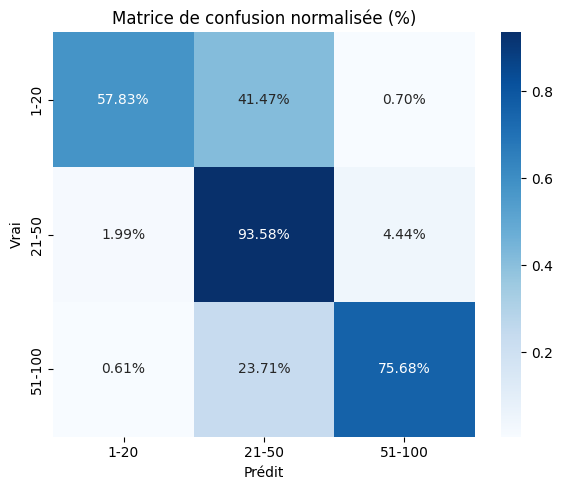


✅ Résultats sauvegardés dans : /kaggle/working/results_age


In [5]:
# -----------------------------
# Imports
# -----------------------------
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Configuration
# -----------------------------
dataset_dir = '/kaggle/input/data-images/images_organisees'
save_dir = '/kaggle/working/results_age'
os.makedirs(save_dir, exist_ok=True)

class_names = ['1-20', '21-50', '51-100']
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
IMG_SIZE = 224
batch_size = 32

# -----------------------------
# Fonction de vérification des images
# -----------------------------
def is_valid_image(path):
    try:
        image = tf.io.read_file(path)
        image = tf.io.decode_jpeg(image, channels=3)
        return True
    except:
        return False

# -----------------------------
# Chargement et nettoyage des données
# -----------------------------
all_paths, all_labels = [], []

print("🔍 Chargement des images...")
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    if not os.path.exists(class_dir):
        raise FileNotFoundError(f"Dossier introuvable : {class_dir}")
    
    total, valid = 0, 0
    for img_name in os.listdir(class_dir):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            total += 1
            path = os.path.join(class_dir, img_name)
            if os.path.getsize(path) == 0:
                continue
            if is_valid_image(path):
                all_paths.append(path)
                all_labels.append(class_to_idx[class_name])
                valid += 1
    print(f"  {class_name}: {valid}/{total} images valides")

all_paths = np.array(all_paths)
all_labels = np.array(all_labels)
print(f"\n✅ Total images valides : {len(all_paths)}")

# -----------------------------
# Distribution originale
# -----------------------------
print("\n📊 Distribution :")
for i, name in enumerate(class_names):
    count = np.sum(all_labels == i)
    pct = count / len(all_labels) * 100
    print(f"  {name}: {count:5d} ({pct:.1f}%)")

# -----------------------------
# Split stratifié (70/15/15)
# -----------------------------
X_temp, X_test, y_temp, y_test = train_test_split(
    all_paths, all_labels, test_size=0.15, stratify=all_labels, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)

# -----------------------------
# Poids de classe
# -----------------------------
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: float(w) for i, w in enumerate(class_weights)}
print("\n⚖️ Poids de classe :", class_weight_dict)

# -----------------------------
# Focal Loss
# -----------------------------
def focal_loss(gamma=2.0, alpha=0.75):
    def loss(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        alpha_t = alpha
        alpha_factor = y_true * alpha_t + (1 - y_true) * (1 - alpha_t)
        focal_weight = tf.pow(1.0 - y_pred, gamma)
        focal_loss = -alpha_factor * focal_weight * tf.math.log(y_pred)
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=1))
    return loss

# -----------------------------
# Fonction de décodage (sécurisée car données nettoyées)
# -----------------------------
def decode_image(path, label):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.float32)
    image = keras.applications.efficientnet.preprocess_input(image)
    return image, label

# -----------------------------
# Data augmentation
# -----------------------------
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomZoom(0.15),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.1),
])

# -----------------------------
# Datasets
# -----------------------------
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .shuffle(buffer_size=2000) \
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)) \
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(decode_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

print("\n✅ Datasets prêts — aucune image corrompue.")

# -----------------------------
# Modèle
# -----------------------------
def build_model(trainable_base=False):
    base_model = keras.applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    base_model.trainable = trainable_base
    
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    outputs = keras.layers.Dense(3, activation='softmax')(x)
    
    return keras.Model(inputs, outputs), base_model

# -----------------------------
# PHASE 1 : Tête seulement
# -----------------------------
print("\n" + "="*60)
print("PHASE 1 : Entraînement de la tête")
print("="*60)

model, base_model = build_model(trainable_base=False)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=['accuracy']
)

callbacks1 = [
    keras.callbacks.ModelCheckpoint(os.path.join(save_dir, 'phase1_best.keras'), save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)
]

history1 = model.fit(
    train_ds, validation_data=val_ds, epochs=25,
    class_weight=class_weight_dict, callbacks=callbacks1
)

# -----------------------------
# PHASE 2 : Fine-tuning
# -----------------------------
print("\n" + "="*60)
print("PHASE 2 : Fine-tuning")
print("="*60)

model = keras.models.load_model(
    os.path.join(save_dir, 'phase1_best.keras'),
    custom_objects={'loss': focal_loss(gamma=2.0, alpha=0.75)}
)

base_model = model.layers[1]
base_model.trainable = True
for layer in base_model.layers[:-70]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=focal_loss(gamma=2.0, alpha=0.75),
    metrics=['accuracy']
)

callbacks2 = [
    keras.callbacks.ModelCheckpoint(os.path.join(save_dir, 'phase2_best.keras'), save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(patience=12, restore_best_weights=True, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-7)
]

history2 = model.fit(
    train_ds, validation_data=val_ds, epochs=30,
    class_weight=class_weight_dict, callbacks=callbacks2
)

# -----------------------------
# ÉVALUATION
# -----------------------------
print("\n" + "="*60)
print("ÉVALUATION FINALE")
print("="*60)

best_model = keras.models.load_model(
    os.path.join(save_dir, 'phase2_best.keras'),
    custom_objects={'loss': focal_loss(gamma=2.0, alpha=0.75)}
)

y_true, y_pred = [], []
for images, labels in test_ds:
    preds = best_model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true, y_pred = np.array(y_true), np.array(y_pred)
test_acc = np.mean(y_true == y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)

print(f"✅ Précision globale      : {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"✅ Balanced Accuracy      : {bal_acc:.4f} ({bal_acc*100:.2f}%)")

print("\n" + "="*60)
print("Rapport de classification :")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Matrice de confusion
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
plt.figure(figsize=(6, 5))
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matrice de confusion normalisée (%)')
plt.ylabel('Vrai')
plt.xlabel('Prédit')
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), dpi=150)
plt.show()

print(f"\n✅ Résultats sauvegardés dans : {save_dir}")

In [9]:
from sklearn.metrics import (
    precision_recall_fscore_support,
    cohen_kappa_score,
    matthews_corrcoef,
    roc_auc_score,
    top_k_accuracy_score
)

# -----------------------------
# 📊 Métriques supplémentaires
# -----------------------------

# 1. Précision, Rappel, F1 (macro & weighted)
precisions, recalls, f1s, _ = precision_recall_fscore_support(
    y_true, y_pred, average=None, labels=[0, 1, 2]
)

f1_macro = np.mean(f1s)
f1_weighted = precision_recall_fscore_support(y_true, y_pred, average='weighted')[2]

# 2. Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)

# 3. MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(y_true, y_pred)

# 4. Top-2 Accuracy
y_proba = []
for images, _ in test_ds:
    probs = best_model.predict(images, verbose=0)
    y_proba.extend(probs)
y_proba = np.array(y_proba)
top2_acc = top_k_accuracy_score(y_true, y_proba, k=2)

# 5. AUC (One-vs-Rest, multi-class)
auc_ovr = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')

# -----------------------------
# 🔎 Affichage complet
# -----------------------------
print(f"✅ Précision globale      : {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"✅ Balanced Accuracy      : {bal_acc:.4f} ({bal_acc*100:.2f}%)")
print(f"✅ F1-score (macro)       : {f1_macro:.4f} ({f1_macro*100:.2f}%)")
print(f"✅ F1-score (weighted)    : {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")
print(f"✅ Cohen's Kappa          : {kappa:.4f}")
print(f"✅ MCC                    : {mcc:.4f}")
print(f"✅ Top-2 Accuracy          : {top2_acc:.4f} ({top2_acc*100:.2f}%)")
print(f"✅ AUC (OvR, macro)       : {auc_ovr:.4f}")

# 🔍 Précision/Rappel/F1 par classe
print("\n" + "="*60)
print("Métriques par classe :")
print("="*60)
for i, name in enumerate(class_names):
    print(f"{name:6} → Precision: {precisions[i]:.4f} | Recall: {recalls[i]:.4f} | F1: {f1s[i]:.4f}")

Invalid SOS parameters for sequential JPEG


✅ Précision globale      : 0.8387 (83.87%)
✅ Balanced Accuracy      : 0.7570 (75.70%)
✅ F1-score (macro)       : 0.7837 (78.37%)
✅ F1-score (weighted)    : 0.8319 (83.19%)
✅ Cohen's Kappa          : 0.6562
✅ MCC                    : 0.6662
✅ Top-2 Accuracy          : 0.9873 (98.73%)
✅ AUC (OvR, macro)       : 0.9146

Métriques par classe :
1-20   → Precision: 0.8944 | Recall: 0.5783 | F1: 0.7024
21-50  → Precision: 0.8413 | Recall: 0.9358 | F1: 0.8860
51-100 → Precision: 0.7685 | Recall: 0.7568 | F1: 0.7626


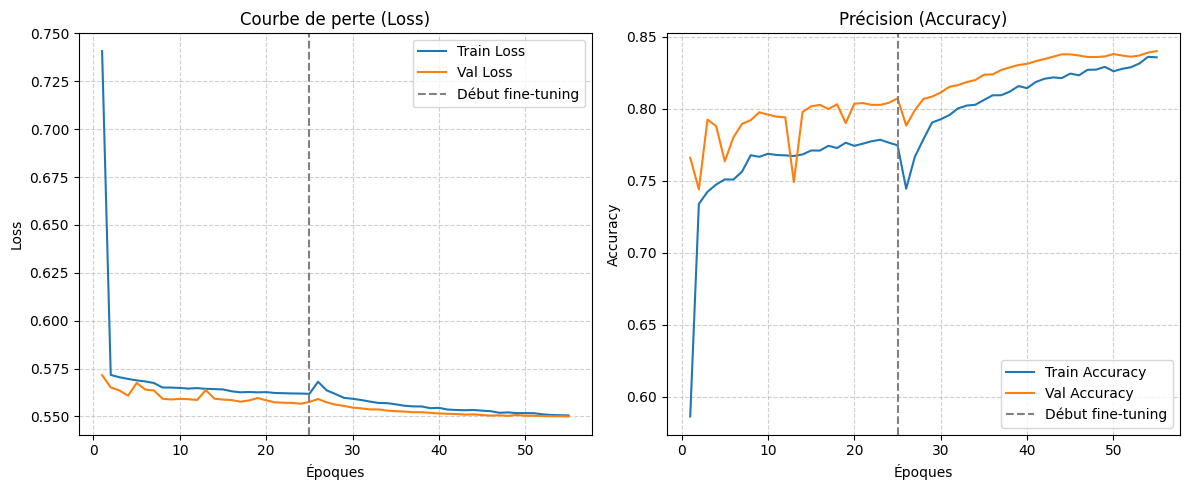

In [10]:
# Combiner les historiques des deux phases
def combine_histories(hist1, hist2):
    combined = {}
    for key in hist1.history.keys():
        combined[key] = hist1.history[key] + hist2.history[key]
    return combined

history_combined = combine_histories(history1, history2)
epochs = range(1, len(history_combined['loss']) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_combined['loss'], label='Train Loss', color='tab:blue')
plt.plot(epochs, history_combined['val_loss'], label='Val Loss', color='tab:orange')
plt.axvline(x=len(history1.history['loss']), color='gray', linestyle='--', label='Début fine-tuning')
plt.title('Courbe de perte (Loss)')
plt.xlabel('Époques')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_combined['accuracy'], label='Train Accuracy', color='tab:blue')
plt.plot(epochs, history_combined['val_accuracy'], label='Val Accuracy', color='tab:orange')
plt.axvline(x=len(history1.history['accuracy']), color='gray', linestyle='--', label='Début fine-tuning')
plt.title('Précision (Accuracy)')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'learning_curves.png'), dpi=150)
plt.show()

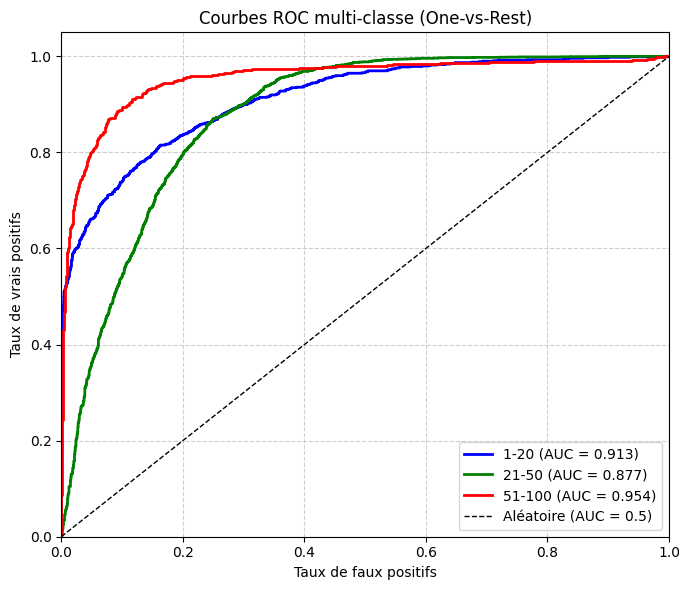

In [12]:
from sklearn.metrics import roc_curve, auc

# Calculer les probabilités si ce n'est pas déjà fait
if 'y_proba' not in locals():
    y_proba = []
    for images, _ in test_ds:
        probs = best_model.predict(images, verbose=0)
        y_proba.extend(probs)
    y_proba = np.array(y_proba)

# One-vs-Rest ROC
plt.figure(figsize=(7, 6))
colors = ['blue', 'green', 'red']
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true == i, y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f'{class_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Aléatoire (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbes ROC multi-classe (One-vs-Rest)')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'roc_curves.png'), dpi=150)
plt.show()